## Importing Modules

In [1]:
import copy
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_recall_fscore_support,log_loss
from sklearn.preprocessing import OneHotEncoder

import tensorflow as tf
import tensorflow
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense,Flatten
from tensorflow.keras.models import save_model
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
import random
import tensorflow_hub as hub

##Load Data

In [80]:

# Opening JSON file
f = open('/content/intents.json')

# returns JSON object as
# a dictionary
data = json.load(f)

# Iterating through the json
# list
for i in data['intents']:
    print(i)

# Closing file
f.close()

{'tag': 'greeting', 'patterns': ['Hi there', 'How are you', 'Is anyone there?', 'Hey', 'Hola', 'Hello', 'Good day'], 'responses': ['Hello, thanks for asking', 'Good to see you again', 'Hi there, how can I help?'], 'context': ['']}
{'tag': 'goodbye', 'patterns': ['Bye', 'See you later', 'Goodbye', 'Nice chatting to you, bye', 'Till next time'], 'responses': ['See you!', 'Have a nice day', 'Bye! Come back again soon.'], 'context': ['']}
{'tag': 'thanks', 'patterns': ['Thanks', 'Thank you', "That's helpful", 'Awesome, thanks', 'Thanks for helping me'], 'responses': ['Happy to help!', 'Any time!', 'My pleasure'], 'context': ['']}
{'tag': 'noanswer', 'patterns': [], 'responses': ["Sorry, can't understand you", 'Please give me more info', 'Not sure I understand'], 'context': ['']}
{'tag': 'options', 'patterns': ['How you could help me?', 'What you can do?', 'What help you provide?', 'How you can be helpful?', 'What support is offered'], 'responses': ['I can guide you through Adverse drug rea

##Preprocess Data

In [81]:
# Turn the array of dictionaries into dataframe
df = pd.DataFrame(data['intents'])
df

,tag,patterns,responses,context
0,greeting,"[Hi there, How are you, Is anyone there?, Hey,...","[Hello, thanks for asking, Good to see you aga...",[]
1,goodbye,"[Bye, See you later, Goodbye, Nice chatting to...","[See you!, Have a nice day, Bye! Come back aga...",[]
2,thanks,"[Thanks, Thank you, That's helpful, Awesome, t...","[Happy to help!, Any time!, My pleasure]",[]
3,noanswer,[],"[Sorry, can't understand you, Please give me m...",[]
4,options,"[How you could help me?, What you can do?, Wha...",[I can guide you through Adverse drug reaction...,[]
5,adverse_drug,"[How to check Adverse drug reaction?, Open adv...",[Navigating to Adverse drug reaction module],[]
6,blood_pressure,"[Open blood pressure module, Task related to b...",[Navigating to Blood Pressure module],[]
7,blood_pressure_search,[I want to search for blood pressure result hi...,"[Please provide Patient ID, Patient ID?]",[search_blood_pressure_by_patient_id]
8,search_blood_pressure_by_patient_id,[],[Loading Blood pressure result for Patient],[]
9,pharmacy_search,"[Find me a pharmacy, Find pharmacy, List of ph...",[Please provide pharmacy name],[search_pharmacy_by_name]


In [4]:
df.head(3)

,tag,patterns,responses,context
0,greeting,"[Hi there, How are you, Is anyone there?, Hey,...","[Hello, thanks for asking, Good to see you aga...",[]
1,goodbye,"[Bye, See you later, Goodbye, Nice chatting to...","[See you!, Have a nice day, Bye! Come back aga...",[]
2,thanks,"[Thanks, Thank you, That's helpful, Awesome, t...","[Happy to help!, Any time!, My pleasure]",[]


In [5]:
df["tag"].value_counts()

greeting                               1
goodbye                                1
thanks                                 1
noanswer                               1
options                                1
adverse_drug                           1
blood_pressure                         1
blood_pressure_search                  1
search_blood_pressure_by_patient_id    1
pharmacy_search                        1
search_pharmacy_by_name                1
hospital_search                        1
search_hospital_by_params              1
search_hospital_by_type                1
Name: tag, dtype: int64

In [4]:
# Explode lists to rows
train_df=df.explode('patterns').reset_index(drop=True)

In [7]:
train_df['patterns']

0                                              Hi there
1                                           How are you
2                                      Is anyone there?
3                                                   Hey
4                                                  Hola
5                                                 Hello
6                                              Good day
7                                                   Bye
8                                         See you later
9                                               Goodbye
10                            Nice chatting to you, bye
11                                       Till next time
12                                               Thanks
13                                            Thank you
14                                       That's helpful
15                                      Awesome, thanks
16                                Thanks for helping me
17                                              

In [5]:
# How long is each sentence on average?
sent_lens= [len(sentence.split()) for sentence in train_df['patterns'].fillna('').to_numpy()]
avg_sent_len = np.mean(sent_lens)
avg_sent_len # return average sentence length (in tokens)


3.5384615384615383

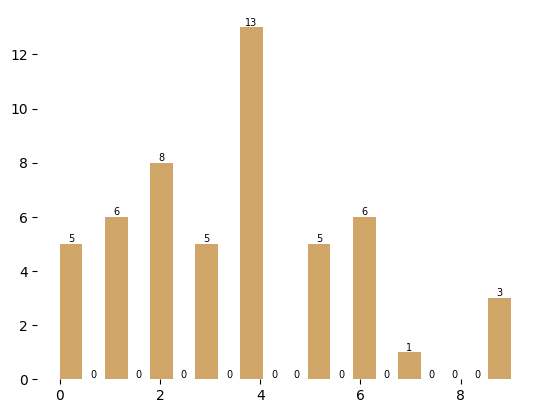

In [8]:
# What does the distribution look like?
fig, ax = plt.subplots()
ax.hist(sent_lens, bins=20,color='#cfa667')
ax.bar_label(ax.containers[0],fontsize=7);
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.savefig('sentence length distribution.png', transparent=True,bbox_inches='tight');

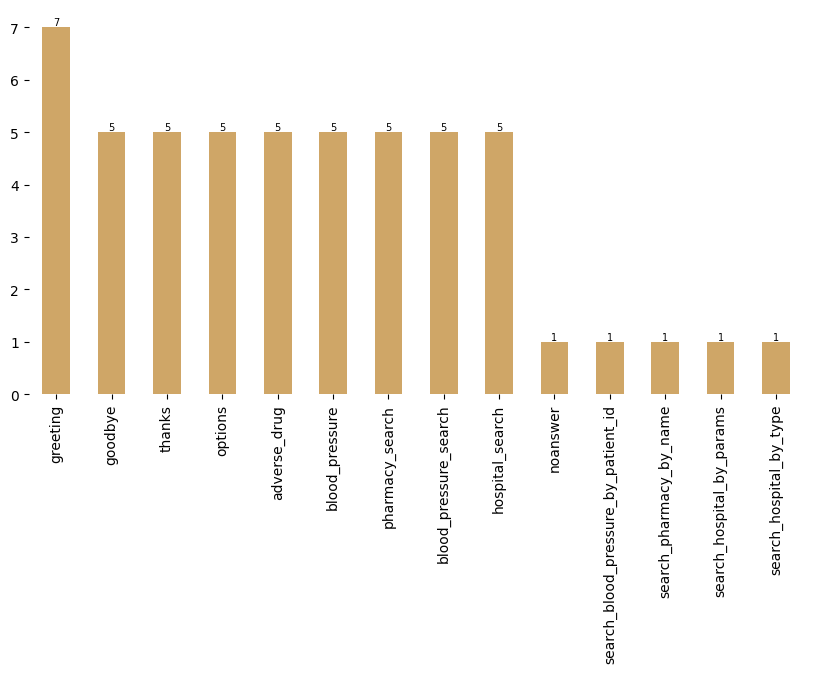

In [9]:
ax=train_df["tag"].value_counts().plot(kind="bar",figsize=(10,5),color = ['#cfa667'])
ax.bar_label(ax.containers[0],fontsize=7);
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.savefig('tag.png', transparent=True,bbox_inches='tight');

In [6]:
train_df[train_df["tag"].str.startswith('search')==True]

,tag,patterns,responses,context
38,search_blood_pressure_by_patient_id,NaN,[Loading Blood pressure result for Patient],[]
44,search_pharmacy_by_name,NaN,[Loading pharmacy details],[]
50,search_hospital_by_params,NaN,[Please provide hospital type],[search_hospital_by_type]
51,search_hospital_by_type,NaN,[Loading hospital details],[]


In [7]:
# exclude rows whose tag starts with search
train_df=train_df[train_df["tag"].str.startswith('search')==False]

In [13]:
train_df

,tag,patterns,responses,context
0,greeting,Hi there,"[Hello, thanks for asking, Good to see you aga...",[]
1,greeting,How are you,"[Hello, thanks for asking, Good to see you aga...",[]
2,greeting,Is anyone there?,"[Hello, thanks for asking, Good to see you aga...",[]
3,greeting,Hey,"[Hello, thanks for asking, Good to see you aga...",[]
4,greeting,Hola,"[Hello, thanks for asking, Good to see you aga...",[]
5,greeting,Hello,"[Hello, thanks for asking, Good to see you aga...",[]
6,greeting,Good day,"[Hello, thanks for asking, Good to see you aga...",[]
7,goodbye,Bye,"[See you!, Have a nice day, Bye! Come back aga...",[]
8,goodbye,See you later,"[See you!, Have a nice day, Bye! Come back aga...",[]
9,goodbye,Goodbye,"[See you!, Have a nice day, Bye! Come back aga...",[]


In [14]:
train_df["tag"].value_counts()

greeting                 7
goodbye                  5
thanks                   5
options                  5
adverse_drug             5
blood_pressure           5
blood_pressure_search    5
pharmacy_search          5
hospital_search          5
noanswer                 1
Name: tag, dtype: int64

In [8]:
# Fill NaN with empty string
train_df=train_df.fillna('')
train_df

,tag,patterns,responses,context
0,greeting,Hi there,"[Hello, thanks for asking, Good to see you aga...",[]
1,greeting,How are you,"[Hello, thanks for asking, Good to see you aga...",[]
2,greeting,Is anyone there?,"[Hello, thanks for asking, Good to see you aga...",[]
3,greeting,Hey,"[Hello, thanks for asking, Good to see you aga...",[]
4,greeting,Hola,"[Hello, thanks for asking, Good to see you aga...",[]
5,greeting,Hello,"[Hello, thanks for asking, Good to see you aga...",[]
6,greeting,Good day,"[Hello, thanks for asking, Good to see you aga...",[]
7,goodbye,Bye,"[See you!, Have a nice day, Bye! Come back aga...",[]
8,goodbye,See you later,"[See you!, Have a nice day, Bye! Come back aga...",[]
9,goodbye,Goodbye,"[See you!, Have a nice day, Bye! Come back aga...",[]


In [9]:
#remove noanswer row from labels
train_df = train_df[train_df.tag != 'noanswer'].reset_index( drop=True)
train_df

,tag,patterns,responses,context
0,greeting,Hi there,"[Hello, thanks for asking, Good to see you aga...",[]
1,greeting,How are you,"[Hello, thanks for asking, Good to see you aga...",[]
2,greeting,Is anyone there?,"[Hello, thanks for asking, Good to see you aga...",[]
3,greeting,Hey,"[Hello, thanks for asking, Good to see you aga...",[]
4,greeting,Hola,"[Hello, thanks for asking, Good to see you aga...",[]
5,greeting,Hello,"[Hello, thanks for asking, Good to see you aga...",[]
6,greeting,Good day,"[Hello, thanks for asking, Good to see you aga...",[]
7,goodbye,Bye,"[See you!, Have a nice day, Bye! Come back aga...",[]
8,goodbye,See you later,"[See you!, Have a nice day, Bye! Come back aga...",[]
9,goodbye,Goodbye,"[See you!, Have a nice day, Bye! Come back aga...",[]


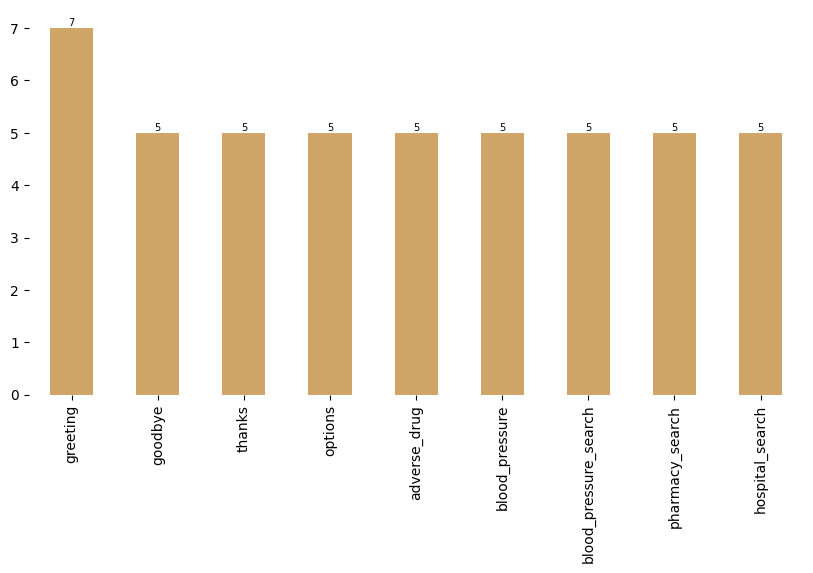

In [14]:
ax=train_df["tag"].value_counts().plot(kind="bar",figsize=(10,5),color = ['#cfa667'])
ax.bar_label(ax.containers[0],fontsize=7);
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.savefig('tag.png', transparent=True,bbox_inches='tight');

In [10]:
# Define X and y
X_train = train_df['patterns'].to_numpy()
y_train = train_df['tag']

In [16]:
X_train.shape

(47,)

In [17]:
# Check the length of X
len(X_train)

47

In [18]:
y_train.unique()

array(['greeting', 'goodbye', 'thanks', 'options', 'adverse_drug',
       'blood_pressure', 'blood_pressure_search', 'pharmacy_search',
       'hospital_search'], dtype=object)

In [19]:
#Check y
y_train

0                  greeting
1                  greeting
2                  greeting
3                  greeting
4                  greeting
5                  greeting
6                  greeting
7                   goodbye
8                   goodbye
9                   goodbye
10                  goodbye
11                  goodbye
12                   thanks
13                   thanks
14                   thanks
15                   thanks
16                   thanks
17                  options
18                  options
19                  options
20                  options
21                  options
22             adverse_drug
23             adverse_drug
24             adverse_drug
25             adverse_drug
26             adverse_drug
27           blood_pressure
28           blood_pressure
29           blood_pressure
30           blood_pressure
31           blood_pressure
32    blood_pressure_search
33    blood_pressure_search
34    blood_pressure_search
35    blood_pressure

In [11]:
# After processing How long is each sentence on average?
sent_lens= [len(sentence.split()) for sentence in X_train]
avg_sent_len = np.mean(sent_lens)
avg_sent_len # return average sentence length (in tokens)


3.9148936170212765

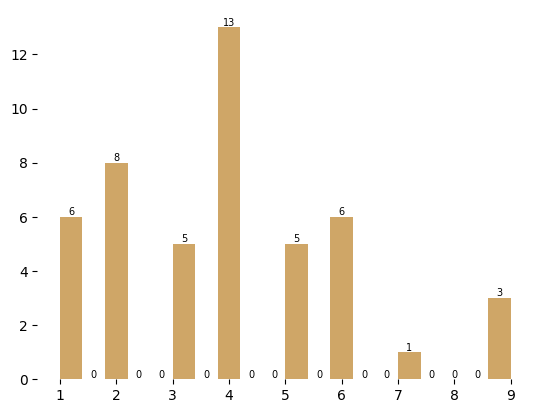

In [21]:
# What does the distribution look like?
fig, ax = plt.subplots()

ax.hist(sent_lens, bins=20,color='#cfa667')
ax.bar_label(ax.containers[0],fontsize=7);
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.savefig('sentence length distribution.png', transparent=True,bbox_inches='tight');

## Label Encode Tag Labels

In [12]:
# Extract labels ("target" columns) and encode them into inegers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(y_train.to_numpy())
# check what training labels look like
train_labels_encoded

array([4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 8, 8, 8, 8, 8, 6, 6, 6, 6, 6,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 7, 7, 7, 7, 7, 5, 5,
       5, 5, 5])

In [13]:
# Get class names and number of classes from LabelEncoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(9,
 array(['adverse_drug', 'blood_pressure', 'blood_pressure_search',
        'goodbye', 'greeting', 'hospital_search', 'options',
        'pharmacy_search', 'thanks'], dtype=object))

In [14]:
# One hot encode labels
# I initially intended to use one-hot encoding for the labels, but the StratifiedKFold splits were not  accepting  one-hot encoded  labels, so I stuck with the encoded numerical representations instead.

from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False) # we want non-sparse matrix
train_labels_one_hot = one_hot_encoder.fit_transform(y_train.to_numpy().reshape(-1,1))


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [15]:
train_labels_one_hot[:5]

array([[0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0.]])

## Model 0: Baseline Model

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create a pipeline
model_0 = Pipeline([
  ("tf-idf", TfidfVectorizer(stop_words="english")),
  ("clf", MultinomialNB())
])
# Create a copy of the model before training
model_0_copy = copy.deepcopy(model_0)
# Fit the pipeline to the training data
model_0.fit(X= X_train,
            y= train_labels_encoded);

In [ ]:
# Evaluate baseline model on training set
model_0.score(X=X_train,
              y=train_labels_encoded)

0.9574468085106383

In [ ]:

# Check log loss
model_0_loss = log_loss(train_labels_encoded, model_0.predict_proba(X_train))
model_0_loss

1.3452625806922054

In [ ]:
# Make predictions using our baseline model
baseline_preds = model_0.predict(X_train)
baseline_preds

array([4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 8, 8, 6, 8, 8, 6, 4, 6, 6, 6,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 7, 7, 7, 7, 7, 5, 5,
       5, 5, 5])

In [ ]:
# Check Labels
train_labels_encoded

array([4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 8, 8, 8, 8, 8, 6, 6, 6, 6, 6,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 7, 7, 7, 7, 7, 5, 5,
       5, 5, 5])

In [ ]:
# Get the cross validation accuracy score
cross_val_score_model_0=cross_val_score(model_0, X_train,train_labels_encoded, cv=5)
cross_val_score_model_0

array([0.9       , 0.7       , 0.55555556, 0.77777778, 0.77777778])

In [ ]:
cross_val_score_model_0.mean()

0.7422222222222222

## Creating datasets (making sure our data loads as fast as possible)


In [ ]:
# Turn our data into TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, train_labels_encoded))
train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [ ]:
train_labels_one_hot.shape, train_labels_encoded[0]

((47, 9), 4)

In [ ]:
# Take the TensorSliceDataset and turn them into prefetch batches
train_dataset = train_dataset.batch(12).prefetch(tf.data.AUTOTUNE)
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [ ]:
# Create an iterator over the dataset
iterator = iter(train_dataset)

# Iterate over the dataset and print the elements of each batch
for batch in iterator:
    print("Batch:")
    for element in batch:
        print(element.numpy().shape)  # Convert tensors to numpy arrays for printing
    print()  # Add a blank line between batches

Batch:
(12,)
(12,)

Batch:
(12,)
(12,)

Batch:
(12,)
(12,)

Batch:
(11,)
(11,)



## Create evaluation function

In [31]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
# Function to evaluate: accuracy, precision, recall, f1-score
def calculate_results(y_true,y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1-score using "weighted" average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results


In [ ]:
baseline_results=calculate_results(y_true=train_labels_encoded,y_pred= baseline_preds)
baseline_results

{'accuracy': 95.74468085106383,
 'precision': 0.9601063829787234,
 'recall': 0.9574468085106383,
 'f1': 0.9569739952718676}

##Model 1: DNN with Tfidf

In [16]:
num_epochs = 50
batchsize= 12

In [ ]:
vectorizer = TfidfVectorizer(stop_words="english")
training_data_tfidf = vectorizer.fit_transform(X_train).toarray()


In [ ]:
training_data_tfidf.shape

(47, 60)

In [ ]:
training_data_tfidf

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.51428741],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [ ]:
len(training_data_tfidf[0])

60

In [ ]:
# creating DNN
model_1_simpleDNN = Sequential()

model_1_simpleDNN.add(Dense(32, input_shape=(len(training_data_tfidf[0]),)))
model_1_simpleDNN.add(Dense(32))
model_1_simpleDNN.add(Dense(16))
model_1_simpleDNN.add(Dense(16))
model_1_simpleDNN.add(Dense(num_classes, activation="softmax"))
model_1_simpleDNN.compile(optimizer="Adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# fitting DNN
model_1_simpleDNN.fit(training_data_tfidf, train_labels_encoded, epochs=num_epochs,batch_size=batchsize,)

# saving model file
save_model(model_1_simpleDNN, "model_1_simpleDNN")

Epoch 1/50
4/4 [==============================] - 1s 5ms/step - loss: 2.1771 - accuracy: 0.1915
Epoch 2/50
4/4 [==============================] - 0s 4ms/step - loss: 2.1285 - accuracy: 0.2766
Epoch 3/50
4/4 [==============================] - 0s 4ms/step - loss: 2.0916 - accuracy: 0.3191
Epoch 4/50
4/4 [==============================] - 0s 4ms/step - loss: 2.0505 - accuracy: 0.3617
Epoch 5/50
4/4 [==============================] - 0s 4ms/step - loss: 2.0106 - accuracy: 0.4255
Epoch 6/50
4/4 [==============================] - 0s 4ms/step - loss: 1.9696 - accuracy: 0.5106
Epoch 7/50
4/4 [==============================] - 0s 4ms/step - loss: 1.9230 - accuracy: 0.5957
Epoch 8/50
4/4 [==============================] - 0s 4ms/step - loss: 1.8775 - accuracy: 0.6170
Epoch 9/50
4/4 [==============================] - 0s 5ms/step - loss: 1.8291 - accuracy: 0.6170
Epoch 10/50
4/4 [==============================] - 0s 4ms/step - loss: 1.7761 - accuracy: 0.6383
Epoch 11/50
4/4 [======================

In [ ]:
model_1_pred_probs = model_1_simpleDNN.predict(training_data_tfidf)
model_1_pred_probs

2/2 [==============================] - 0s 4ms/step


array([[1.04261955e-04, 8.40533699e-04, 5.86442695e-07, 1.91722647e-04,
        9.93686497e-01, 3.72074917e-03, 2.71802710e-04, 8.67452938e-04,
        3.16514081e-04],
       [9.89234447e-03, 5.30131795e-02, 6.13587536e-03, 3.77263464e-02,
        5.23895144e-01, 1.16637729e-01, 1.31229341e-01, 4.87610698e-02,
        7.27090016e-02],
       [9.89234447e-03, 5.30131795e-02, 6.13587536e-03, 3.77263464e-02,
        5.23895144e-01, 1.16637729e-01, 1.31229341e-01, 4.87610698e-02,
        7.27090016e-02],
       [1.50533102e-04, 6.53274241e-04, 8.53350386e-08, 8.59637876e-05,
        9.97608364e-01, 5.59058622e-04, 6.72875249e-05, 8.49600125e-04,
        2.56732128e-05],
       [6.73467002e-05, 5.96237194e-04, 3.85996685e-07, 3.45771332e-05,
        9.93909299e-01, 1.29976624e-03, 1.74351182e-04, 3.65109486e-03,
        2.67005322e-04],
       [2.46376352e-04, 8.61416629e-04, 3.46776176e-07, 1.25713428e-04,
        9.95250285e-01, 1.21101667e-03, 1.29861684e-04, 2.10238551e-03,
        7.2

In [ ]:
# Convert pred probs to classes
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(47,), dtype=int64, numpy=
array([4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 8, 8, 6, 8, 8, 6, 4, 6, 6, 6,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 7, 7, 7, 7, 7, 5, 5,
       5, 5, 5])>

In [ ]:
train_labels_encoded

array([4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 8, 8, 8, 8, 8, 6, 6, 6, 6, 6,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 7, 7, 7, 7, 7, 5, 5,
       5, 5, 5])

In [ ]:
model_1_results = calculate_results(y_true=train_labels_encoded,y_pred= model_1_preds)
model_1_results

{'accuracy': 95.74468085106383,
 'precision': 0.9601063829787234,
 'recall': 0.9574468085106383,
 'f1': 0.9569739952718676}

##Instantiating text vectorizer and token embedder

In [ ]:
# How long of a sentence length covers 95% of examples?
int(np.percentile(sent_lens, 95))

8

In [ ]:
# Maximum sequence length in the training set
max(sent_lens)

9

In [ ]:
# Set the vectorizer output sequence length to the maximum sentence length
output_seq_len= max(sent_lens)

In [ ]:
# How many words are in our vocab?
max_tokens = 5000

In [ ]:
# Create text vectorizer
text_vectorizer = TextVectorization(max_tokens = max_tokens, # number of words in vocabulary
                                    standardize='lower_and_strip_punctuation',
                                    output_sequence_length=output_seq_len) # desired  output length of vectorized sequences

In [ ]:
# Adapt text vectorizer to training sentences
text_vectorizer.adapt(X_train)

In [ ]:
# Test out text vectorizer on random sentences
target_sentence = random.choice(X_train)
print(f"Text:\n{target_sentence}")
print(f"\nLength of text:{len(target_sentence.split())}")
print(f"\nVectorized text:{text_vectorizer([target_sentence])}")
print(f"\nVectorized text shape:{text_vectorizer([target_sentence]).shape}")

Text:
Thanks

Length of text:1

Vectorized text:[[16  0  0  0  0  0  0  0  0]]

Vectorized text shape:(1, 9)


In [ ]:
# How many words in our training vocabulary
text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocab:{len(text_vocab)}")
print(f"Most common words in vocab:{text_vocab[:5]}")
print(f"Last common words in vocab:{text_vocab[-5:]}")

Number of words in vocab:91
Most common words in vocab:['', '[UNK]', 'pressure', 'blood', 'you']
Last common words in vocab:['be', 'awesome', 'are', 'anyone', 'all']


In [ ]:
# Create token embedding layer
token_embed = tf.keras.layers.Embedding(input_dim = len(text_vocab), # length of vocabulary
                              output_dim=64, # Note: different embedding sizes results in drastically different numbers of parameters to train
                              mask_zero=True, # use masking to handle variable sequence lengths (save space),
                               input_length= output_seq_len,
                              name="token_embedding")

In [ ]:
# Show  example embedding
print(f"Sentence before vectorization:\n {target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization (before embedding):\n {vectorized_sentence}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Embedded Sentence shape: {embedded_sentence.shape}")
#print(f"Sentence after embedding:\n {embedded_sentence}\n")

Sentence before vectorization:
 Thanks

Sentence after vectorization (before embedding):
 [[16  0  0  0  0  0  0  0  0]]

Embedded Sentence shape: (1, 9, 64)


## Model 2: DNN with Custom token embedding

In [ ]:
# Define the model
model_2_DNN_with_tokenembed = tf.keras.Sequential([
    text_vectorizer,
    token_embed,
    Flatten(),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(num_classes, activation='softmax')
])
model_2_DNN_with_tokenembed.compile(optimizer='Adam', loss="sparse_categorical_crossentropy", metrics=["accuracy"])


# fitting DNN
model_2_DNN_with_tokenembed.fit(X_train, train_labels_encoded, epochs=num_epochs,batch_size=batchsize)

# saving model file
save_model(model_2_DNN_with_tokenembed, "model2_DNN_with_tokenembed")

Epoch 1/50
4/4 [==============================] - 4s 17ms/step - loss: 2.1944 - accuracy: 0.1277
Epoch 2/50
4/4 [==============================] - 0s 7ms/step - loss: 2.1622 - accuracy: 0.3404
Epoch 3/50
4/4 [==============================] - 0s 8ms/step - loss: 2.1352 - accuracy: 0.4255
Epoch 4/50
4/4 [==============================] - 0s 23ms/step - loss: 2.1061 - accuracy: 0.4468
Epoch 5/50
4/4 [==============================] - 0s 9ms/step - loss: 2.0731 - accuracy: 0.4468
Epoch 6/50
4/4 [==============================] - 0s 9ms/step - loss: 2.0345 - accuracy: 0.4468
Epoch 7/50
4/4 [==============================] - 0s 11ms/step - loss: 1.9888 - accuracy: 0.5532
Epoch 8/50
4/4 [==============================] - 0s 11ms/step - loss: 1.9375 - accuracy: 0.6596
Epoch 9/50
4/4 [==============================] - 0s 12ms/step - loss: 1.8756 - accuracy: 0.6596
Epoch 10/50
4/4 [==============================] - 0s 13ms/step - loss: 1.7996 - accuracy: 0.7021
Epoch 11/50
4/4 [================

In [ ]:
model_2_DNN_with_tokenembed.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 9)                 0         
 ctorization)                                                    
                                                                 
 token_embedding (Embedding  (None, 9, 64)             5824      
 )                                                               
                                                                 
 flatten (Flatten)           (None, 576)               0         
                                                                 
 dense_5 (Dense)             (None, 64)                36928     
                                                                 
 dense_6 (Dense)             (None, 32)                2080      
                                                                 
 dense_7 (Dense)             (None, 9)                

In [ ]:
# Make predictions (our model predicts prediction probabilities for each class)
model_2_pred_probs = model_2_DNN_with_tokenembed.predict(train_dataset)
model_2_pred_probs.shape

4/4 [==============================] - 0s 3ms/step


(47, 9)

In [ ]:
# Convert pred probs to classes
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds

<tf.Tensor: shape=(47,), dtype=int64, numpy=
array([4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 8, 8, 8, 8, 8, 6, 6, 6, 6, 6,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 7, 7, 7, 7, 7, 5, 5,
       5, 5, 5])>

In [ ]:
# Calculate model_2 results
model_2_results = calculate_results(y_true=train_labels_encoded,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 100.0, 'precision': 1.0, 'recall': 1.0, 'f1': 1.0}

##Model 3:Conv1D with token embeddings

In [ ]:
# Create 1D conv model to process sequences
inputs = tf.keras.layers.Input(shape=(1,), dtype= tf.string)
text_vectors = text_vectorizer (inputs) # vectorize text inputs
token_embeddings = token_embed(text_vectors) # create embedding
x = tf.keras.layers.Conv1D(64, kernel_size=5, padding="same", activation= "relu")(token_embeddings)
x = tf.keras.layers.GlobalAveragePooling1D()(x) # condense the output of our feature vector
outputs = tf.keras.layers.Dense(num_classes, activation="softmax")(x)
model_3_Conv1D_with_tokenembed = tf.keras.Model(inputs, outputs)


# Compile
model_3_Conv1D_with_tokenembed.compile(loss="sparse_categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
# Get summary of Conv1D model
model_3_Conv1D_with_tokenembed.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 9)                 0         
 ctorization)                                                    
                                                                 
 token_embedding (Embedding  (None, 9, 64)             5824      
 )                                                               
                                                                 
 conv1d (Conv1D)             (None, 9, 64)             20544     
                                                                 
 global_average_pooling1d (  (None, 64)                0         
 GlobalAveragePooling1D)                                         
                                                             

In [ ]:
len(train_dataset)

4

In [ ]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [ ]:
# Fit the model
history_model_3= model_3_Conv1D_with_tokenembed.fit(X_train,
                              train_labels_encoded,
                             epochs=num_epochs,
                             batch_size=batchsize
                             )

Epoch 1/50
4/4 [==============================] - 3s 11ms/step - loss: 2.1992 - accuracy: 0.1277
Epoch 2/50
4/4 [==============================] - 0s 14ms/step - loss: 2.1628 - accuracy: 0.3830
Epoch 3/50
4/4 [==============================] - 0s 11ms/step - loss: 2.1355 - accuracy: 0.5106
Epoch 4/50
4/4 [==============================] - 0s 10ms/step - loss: 2.1069 - accuracy: 0.5106
Epoch 5/50
4/4 [==============================] - 0s 11ms/step - loss: 2.0785 - accuracy: 0.5957
Epoch 6/50
4/4 [==============================] - 0s 9ms/step - loss: 2.0463 - accuracy: 0.6170
Epoch 7/50
4/4 [==============================] - 0s 12ms/step - loss: 2.0096 - accuracy: 0.5957
Epoch 8/50
4/4 [==============================] - 0s 17ms/step - loss: 1.9684 - accuracy: 0.5957
Epoch 9/50
4/4 [==============================] - 0s 9ms/step - loss: 1.9245 - accuracy: 0.5957
Epoch 10/50
4/4 [==============================] - 0s 8ms/step - loss: 1.8690 - accuracy: 0.5957
Epoch 11/50
4/4 [===============

In [ ]:
# Make predictions (our model predicts prediction probabilities for each class)
model_3_pred_probs = model_3_Conv1D_with_tokenembed.predict(train_dataset)
model_3_pred_probs.shape

4/4 [==============================] - 0s 7ms/step


(47, 9)

In [ ]:
# Convert pred probs to classes
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_preds

<tf.Tensor: shape=(47,), dtype=int64, numpy=
array([4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 8, 8, 8, 8, 8, 6, 6, 6, 6, 6,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 7, 7, 7, 7, 7, 5, 5,
       5, 5, 5])>

In [ ]:
# Calculate model_3 results
model_3_results = calculate_results(y_true=train_labels_encoded,
                                    y_pred=model_3_preds)
model_3_results

{'accuracy': 100.0, 'precision': 1.0, 'recall': 1.0, 'f1': 1.0}

In [ ]:
baseline_results

{'accuracy': 95.74468085106383,
 'precision': 0.9601063829787234,
 'recall': 0.9574468085106383,
 'f1': 0.9569739952718676}

## Model 4: Bi-LSTM

In [ ]:
model_4_BiLSTM = tf.keras.Sequential([
    text_vectorizer,
    token_embed,
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(num_classes,activation="softmax")
])
# Compile
model_4_BiLSTM.compile(loss="sparse_categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics=["accuracy"])




In [ ]:
# Fit the model
history_model_4= model_4_BiLSTM.fit(X_train,
                              train_labels_encoded,
                              epochs=num_epochs,batch_size=batchsize
                             )

Epoch 1/50
4/4 [==============================] - 15s 14ms/step - loss: 2.1706 - accuracy: 0.2979
Epoch 2/50
4/4 [==============================] - 0s 13ms/step - loss: 2.1037 - accuracy: 0.6170
Epoch 3/50
4/4 [==============================] - 0s 13ms/step - loss: 2.0416 - accuracy: 0.7021
Epoch 4/50
4/4 [==============================] - 0s 13ms/step - loss: 1.9751 - accuracy: 0.8298
Epoch 5/50
4/4 [==============================] - 0s 14ms/step - loss: 1.8988 - accuracy: 0.8298
Epoch 6/50
4/4 [==============================] - 0s 23ms/step - loss: 1.8118 - accuracy: 0.8723
Epoch 7/50
4/4 [==============================] - 0s 30ms/step - loss: 1.7080 - accuracy: 0.9574
Epoch 8/50
4/4 [==============================] - 0s 31ms/step - loss: 1.5856 - accuracy: 0.9787
Epoch 9/50
4/4 [==============================] - 0s 27ms/step - loss: 1.4578 - accuracy: 0.9787
Epoch 10/50
4/4 [==============================] - 0s 25ms/step - loss: 1.3127 - accuracy: 0.9787
Epoch 11/50
4/4 [===========

In [ ]:
# Make predictions (our model predicts prediction probabilities for each class)
model_4_pred_probs = model_4_BiLSTM.predict(train_dataset)
model_4_pred_probs.shape

4/4 [==============================] - 3s 5ms/step


(47, 9)

In [ ]:
# Convert pred probs to classes
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_preds

<tf.Tensor: shape=(47,), dtype=int64, numpy=
array([4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 8, 8, 8, 8, 8, 6, 6, 6, 6, 6,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 7, 7, 7, 7, 7, 5, 5,
       5, 5, 5])>

In [ ]:
# Calculate model_4 results
model_4_results = calculate_results(y_true=train_labels_encoded,
                                    y_pred=model_4_preds)
model_4_results

{'accuracy': 100.0, 'precision': 1.0, 'recall': 1.0, 'f1': 1.0}

In [ ]:
baseline_results

{'accuracy': 95.74468085106383,
 'precision': 0.9601063829787234,
 'recall': 0.9574468085106383,
 'f1': 0.9569739952718676}

##Model 5: Universal Sentence Encoding (USE)

In [15]:
import tensorflow_hub as hub
# Create a Keras Layer using the USE pretrained layer from tensorflow hub
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[],
                                        dtype=tf.string,
                                        trainable=False,
                                        name="USE"
                                        )
# Create model using the Sequential API
model_5_USE = tf.keras.Sequential([
  sentence_encoder_layer,
  Dense(64, activation="relu"),
  tf.keras.layers.Dense(num_classes,activation="softmax")
], name = "model_5_USE")

# Compile
model_5_USE.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])


model_5_USE.summary()

Model: "model_5_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense (Dense)               (None, 64)                32832     
                                                                 
 dense_1 (Dense)             (None, 9)                 585       
                                                                 
Total params: 256831241 (979.73 MB)
Trainable params: 33417 (130.54 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [17]:
# Train a classifier on top of USE pretrained embeddings
model_5_history = model_5_USE.fit(X_train,
                              train_labels_encoded,
                               epochs=num_epochs,
                              batch_size=batchsize
                              )

Epoch 1/50
4/4 [==============================] - 3s 11ms/step - loss: 2.1862 - accuracy: 0.1915
Epoch 2/50
4/4 [==============================] - 0s 9ms/step - loss: 2.0937 - accuracy: 0.5957
Epoch 3/50
4/4 [==============================] - 0s 9ms/step - loss: 2.0128 - accuracy: 0.7234
Epoch 4/50
4/4 [==============================] - 0s 9ms/step - loss: 1.9308 - accuracy: 0.7447
Epoch 5/50
4/4 [==============================] - 0s 9ms/step - loss: 1.8461 - accuracy: 0.7660
Epoch 6/50
4/4 [==============================] - 0s 12ms/step - loss: 1.7593 - accuracy: 0.7872
Epoch 7/50
4/4 [==============================] - 0s 10ms/step - loss: 1.6666 - accuracy: 0.8298
Epoch 8/50
4/4 [==============================] - 0s 9ms/step - loss: 1.5735 - accuracy: 0.8511
Epoch 9/50
4/4 [==============================] - 0s 10ms/step - loss: 1.4768 - accuracy: 0.8723
Epoch 10/50
4/4 [==============================] - 0s 9ms/step - loss: 1.3818 - accuracy: 0.8511
Epoch 11/50
4/4 [==================

In [ ]:
# Train a classifier on top of USE pretrained embeddings
model_5_history = model_5_USE.fit(X_train,
                              train_labels_encoded,
                               epochs=num_epochs,
                              batch_size=batchsize
                              )


Epoch 1/50
4/4 [==============================] - 3s 8ms/step - loss: 2.1980 - accuracy: 0.0851
Epoch 2/50
4/4 [==============================] - 0s 8ms/step - loss: 2.1134 - accuracy: 0.5532
Epoch 3/50
4/4 [==============================] - 0s 9ms/step - loss: 2.0368 - accuracy: 0.7660
Epoch 4/50
4/4 [==============================] - 0s 10ms/step - loss: 1.9623 - accuracy: 0.9574
Epoch 5/50
4/4 [==============================] - 0s 8ms/step - loss: 1.8786 - accuracy: 0.9574
Epoch 6/50
4/4 [==============================] - 0s 8ms/step - loss: 1.7918 - accuracy: 0.9787
Epoch 7/50
4/4 [==============================] - 0s 8ms/step - loss: 1.7016 - accuracy: 0.9787
Epoch 8/50
4/4 [==============================] - 0s 9ms/step - loss: 1.6087 - accuracy: 0.9787
Epoch 9/50
4/4 [==============================] - 0s 8ms/step - loss: 1.5124 - accuracy: 0.9787
Epoch 10/50
4/4 [==============================] - 0s 8ms/step - loss: 1.4176 - accuracy: 0.9787
Epoch 11/50
4/4 [=====================

In [ ]:
# Make predictions (our model predicts prediction probabilities for each class)
model_5_pred_probs = model_5_USE.predict(train_dataset)


4/4 [==============================] - 1s 11ms/step


In [ ]:
model_5_pred_probs.shape

(47, 9)

In [ ]:
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
model_5_preds

<tf.Tensor: shape=(47,), dtype=int64, numpy=
array([4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 8, 8, 8, 8, 8, 6, 6, 6, 6, 6,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 7, 7, 7, 7, 7, 5, 5,
       5, 5, 5])>

In [ ]:
# Calculate model_2 results
model_5_results = calculate_results(y_true=train_labels_encoded,
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 100.0, 'precision': 1.0, 'recall': 1.0, 'f1': 1.0}

## Model 6: Fine-Tuning DistilBERT

In [25]:
import transformers
print(transformers.__version__)

4.38.2


In [26]:
from transformers import DistilBertTokenizerFast, TFDistilBertForSequenceClassification
from keras import backend as K

In [19]:
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

In [20]:
train_encodings = tokenizer(list(X_train), truncation=True, padding=True)

train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train_labels_encoded
))


In [23]:
from keras import backend as K
model_6 = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased',num_labels=num_classes)
# Currently does not work due to mismatched tf and keras versions https://discuss.huggingface.co/t/pretrain-model-not-accepting-optimizer/76209
#optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
model_6.compile(optimizer="Adam", loss='sparse_categorical_crossentropy',metrics=["accuracy"]) # can also use any keras loss fn
K.set_value(model_6.optimizer.learning_rate, 1e-5)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [24]:
model_6.fit(train_dataset.batch(12), epochs=50,batch_size=12)

Epoch 1/50
4/4 [==============================] - 28s 135ms/step - loss: 6.2769 - accuracy: 0.1064
Epoch 2/50
4/4 [==============================] - 0s 57ms/step - loss: 5.5750 - accuracy: 0.1489
Epoch 3/50
4/4 [==============================] - 0s 48ms/step - loss: 3.4865 - accuracy: 0.1277
Epoch 4/50
4/4 [==============================] - 0s 44ms/step - loss: 3.3018 - accuracy: 0.1489
Epoch 5/50
4/4 [==============================] - 0s 42ms/step - loss: 3.8282 - accuracy: 0.1064
Epoch 6/50
4/4 [==============================] - 0s 43ms/step - loss: 2.4466 - accuracy: 0.2979
Epoch 7/50
4/4 [==============================] - 0s 42ms/step - loss: 2.0595 - accuracy: 0.2766
Epoch 8/50
4/4 [==============================] - 0s 46ms/step - loss: 1.9161 - accuracy: 0.2979
Epoch 9/50
4/4 [==============================] - 0s 43ms/step - loss: 2.1313 - accuracy: 0.2128
Epoch 10/50
4/4 [==============================] - 0s 42ms/step - loss: 2.0928 - accuracy: 0.4043
Epoch 11/50
4/4 [==========

In [33]:
encoding = tokenizer(['Hi, how are you?'], truncation=True, padding=True,return_tensors='tf')
pred = model_6.predict(encoding)
predproba=tf.nn.softmax(pred['logits'])[0]
pred=np.argmax(predproba, 0)

1/1 [==============================] - 0s 420ms/step


In [29]:
encoding

{'input_ids': <tf.Tensor: shape=(1, 8), dtype=int32, numpy=array([[ 101, 7632, 1010, 2129, 2024, 2017, 1029,  102]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(1, 8), dtype=int32, numpy=array([[1, 1, 1, 1, 1, 1, 1, 1]], dtype=int32)>}

In [32]:
predproba[0]

<tf.Tensor: shape=(9,), dtype=float32, numpy=
array([0.1068016 , 0.11423035, 0.10919261, 0.11402554, 0.12616931,
       0.10263844, 0.11026139, 0.11075409, 0.1059267 ], dtype=float32)>

In [34]:
pred

4

In [ ]:
# Making prediction on the training data

In [25]:
model_6_preds=model_6.predict(train_dataset)
model_6_predproba=tf.nn.softmax(model_6_preds['logits'])


47/47 [==============================] - 3s 5ms/step


In [26]:
model_6_predproba

<tf.Tensor: shape=(47, 9), dtype=float32, numpy=
array([[0.10866989, 0.10844894, 0.11591776, 0.11024744, 0.12941696,
        0.10497218, 0.10923971, 0.1028831 , 0.11020396],
       [0.11120606, 0.10500931, 0.10591418, 0.11048766, 0.1327123 ,
        0.1034029 , 0.11377978, 0.10681143, 0.11067637],
       [0.10958533, 0.1060843 , 0.11226783, 0.10453063, 0.13880892,
        0.10147092, 0.11269452, 0.10639638, 0.10816116],
       [0.10671408, 0.10563958, 0.11242088, 0.10904021, 0.13429053,
        0.10851259, 0.10795286, 0.10415591, 0.11127339],
       [0.10543617, 0.11207785, 0.10421938, 0.11137852, 0.13207753,
        0.10660104, 0.10793014, 0.11173193, 0.10854746],
       [0.10686819, 0.10428891, 0.11383141, 0.11249205, 0.13377993,
        0.10653531, 0.10891151, 0.1034449 , 0.10984781],
       [0.10524616, 0.10829845, 0.10995311, 0.11031685, 0.1369999 ,
        0.10338477, 0.1041254 , 0.10758103, 0.11409437],
       [0.10700637, 0.10530413, 0.1076296 , 0.15558028, 0.10773018,
        

In [27]:
model_6_preds=np.argmax(model_6_predproba, 1)

In [28]:
model_6_preds

array([4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 8, 8, 8, 8, 8, 6, 6, 6, 6, 6,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 7, 7, 7, 7, 7, 5, 5,
       5, 5, 5])

In [29]:
train_labels_encoded

array([4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 8, 8, 8, 8, 8, 6, 6, 6, 6, 6,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 7, 7, 7, 7, 7, 5, 5,
       5, 5, 5])

In [32]:
model_6_results=calculate_results(y_true=train_labels_encoded,
                                    y_pred=model_6_preds)
model_6_results

{'accuracy': 100.0, 'precision': 1.0, 'recall': 1.0, 'f1': 1.0}

## Cross Validation

In [16]:
num_epochs = 50
batchsize= 12

In [17]:
from sklearn.model_selection import StratifiedKFold
from transformers import DistilBertTokenizerFast, TFDistilBertForSequenceClassification
from keras import backend as K
# Define K-fold cross-validation
#random.seed(42)
k_folds = 5
skf = StratifiedKFold(n_splits=k_folds, shuffle=True,random_state=42)


max_tokens = 5000
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[],
                                        dtype=tf.string,
                                        trainable=False,
                                        name="USE"
                                        )

# Initialize list to store cross-validation scores
model_0_cv_scores = []
model_1_cv_scores = []
model_2_cv_scores=  []
model_3_cv_scores=  []
model_4_cv_scores=  []
model_5_cv_scores=  []
model_6_cv_scores = []

# Perform cross-validation
for train_index, val_index in skf.split(X_train, train_labels_encoded):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = train_labels_encoded[train_index], train_labels_encoded[val_index]

    tfidfvectorizer = TfidfVectorizer(stop_words="english")
     #How long is each sentence on average?
    sent_lens= [len(sentence.split()) for sentence in X_train_fold]
    # Set the vectorizer output sequence length to the maximum sentence length
    output_seq_len= max(sent_lens)
    # How many words are in our vocab?
    # Create text vectorizer
    text_vectorizer = TextVectorization(max_tokens = max_tokens, # number of words in vocabulary
                                    standardize='lower_and_strip_punctuation',
                                    output_sequence_length=output_seq_len) # desired  output length of vectorized sequences
    # Adapt text vectorizer to training sentences
    text_vectorizer.adapt(X_train_fold)

    # How many words in our training vocabulary
    text_vocab = text_vectorizer.get_vocabulary()
    # Create token embedding layer
    token_embed = tf.keras.layers.Embedding(input_dim = len(text_vocab), # length of vocabulary
                              output_dim=64, # Note: different embedding sizes results in drastically different numbers of parameters to train
                              mask_zero=True, # use masking to handle variable sequence lengths (save space),
                               input_length= output_seq_len,
                              name="token_embedding")


    training_data_tfidf_cv = tfidfvectorizer.fit_transform(X_train_fold).toarray()
    val_data_tfidf_cv = tfidfvectorizer.transform(X_val_fold).toarray()

    # For model6
    tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
    train_encodings = tokenizer(list(X_train_fold), truncation=True, padding=True)
    val_encodings = tokenizer(list(X_val_fold), truncation=True, padding=True)

    train_dataset = tf.data.Dataset.from_tensor_slices((
        dict(train_encodings),
        y_train_fold
    ))

    val_dataset=tf.data.Dataset.from_tensor_slices((
        dict(val_encodings),
        y_val_fold
    ))

    # Calculate the padding width for the second dimension
    #padding_width = 60 - training_data_tfidf_cv.shape[1]
    # Pad the array with zeros on the right side of the second dimension
    #padded_training_data_tfidf_cv = np.pad(training_data_tfidf_cv, ((0, 0), (0, padding_width)), 'constant', constant_values=0)
    # Calculate the padding width for the second dimension
    #padding_width = 60 - val_data_tfidf_cv.shape[1]
    # Pad the array with zeros on the right side of the second dimension
    #padded_val_data_tfidf_cv = np.pad(val_data_tfidf_cv, ((0, 0), (0, padding_width)), 'constant', constant_values=0)

    # Redefine copies of Models
    # Model 0
    model_0_copy = Pipeline([
    ("tf-idf", TfidfVectorizer(stop_words="english")),
    ("clf", MultinomialNB())
    ])
    # Model 1
    model_1_copy_simpleDNN = Sequential()
    model_1_copy_simpleDNN.add(Dense(32, input_shape=(len(training_data_tfidf_cv[0]),)))
    model_1_copy_simpleDNN.add(Dense(32))
    model_1_copy_simpleDNN.add(Dense(16))
    model_1_copy_simpleDNN.add(Dense(16))
    model_1_copy_simpleDNN.add(Dense(num_classes, activation="softmax"))
    model_1_copy_simpleDNN.compile(optimizer="Adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    # Model 2
    model_2_copy_DNN_with_tokenembed = tf.keras.Sequential([
    text_vectorizer,
    token_embed,
    Flatten(),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(num_classes, activation='softmax')
    ])
    model_2_copy_DNN_with_tokenembed.compile(optimizer='Adam', loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    # Model 3
    inputs = tf.keras.layers.Input(shape=(1,), dtype= tf.string)
    text_vectors = text_vectorizer (inputs) # vectorize text inputs
    token_embeddings = token_embed(text_vectors) # create embedding
    x = tf.keras.layers.Conv1D(64, kernel_size=5, padding="same", activation= "relu")(token_embeddings)
    x = tf.keras.layers.GlobalAveragePooling1D()(x) # condense the output of our feature vector
    outputs = tf.keras.layers.Dense(num_classes, activation="softmax")(x)
    model_3_copy_Conv1D_with_tokenembed = tf.keras.Model(inputs, outputs)
    model_3_copy_Conv1D_with_tokenembed.compile(loss="sparse_categorical_crossentropy",
                    optimizer = tf.keras.optimizers.Adam(),
                    metrics=["accuracy"])
    # Model 4
    model_4_copy_BiLSTM = tf.keras.Sequential([
    text_vectorizer,
    token_embed,
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(num_classes,activation="softmax")
    ])
    model_4_copy_BiLSTM.compile(loss="sparse_categorical_crossentropy",
                    optimizer = tf.keras.optimizers.Adam(),
                    metrics=["accuracy"])
    # Model 5
    model_5_copy_USE = tf.keras.Sequential([
      sentence_encoder_layer,
      Dense(64, activation="relu"),
      tf.keras.layers.Dense(num_classes,activation="softmax")
    ], name = "model_5_USE")

    model_5_copy_USE.compile(loss="sparse_categorical_crossentropy",
                    optimizer=tf.keras.optimizers.Adam(),
                    metrics=["accuracy"])


    # Model 6
    model_6_copy = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased',num_labels=num_classes)
    model_6_copy.compile(optimizer="Adam", loss='sparse_categorical_crossentropy',metrics=["accuracy"]) # can also use any keras loss fn
    K.set_value(model_6_copy.optimizer.learning_rate, 1e-5)






    # Fit the models on the training fold
    model_0_copy.fit(X_train_fold, y_train_fold)
    model_1_copy_simpleDNN.fit(training_data_tfidf_cv, y_train_fold,verbose=0,epochs=num_epochs,batch_size=batchsize)
    model_2_copy_DNN_with_tokenembed.fit(X_train_fold, y_train_fold,verbose=0,epochs=num_epochs,batch_size=batchsize)
    model_3_copy_Conv1D_with_tokenembed.fit(X_train_fold, y_train_fold,verbose=0,epochs=num_epochs,batch_size=batchsize)
    model_4_copy_BiLSTM.fit(X_train_fold, y_train_fold,verbose=0,epochs=num_epochs,batch_size=batchsize)
    model_5_copy_USE.fit(X_train_fold, y_train_fold,verbose=0,epochs=num_epochs,batch_size=batchsize)
    model_6_copy.fit(train_dataset.batch(12),verbose=0,epochs=num_epochs,batch_size=batchsize)
    # Evaluate the model on the validation fold
    model_0_fold_score = [log_loss(y_val_fold, model_0_copy.predict_proba(X_val_fold)),model_0_copy.score(X_val_fold, y_val_fold)]
    model_1_fold_score = model_1_copy_simpleDNN.evaluate(val_data_tfidf_cv, y_val_fold, verbose=0)
    model_2_fold_score = model_2_copy_DNN_with_tokenembed.evaluate(X_val_fold, y_val_fold, verbose=0)
    model_3_fold_score = model_3_copy_Conv1D_with_tokenembed.evaluate(X_val_fold, y_val_fold, verbose=0)
    model_4_fold_score = model_4_copy_BiLSTM.evaluate(X_val_fold, y_val_fold, verbose=0)
    model_5_fold_score = model_5_copy_USE.evaluate(X_val_fold, y_val_fold, verbose=0)
    model_6_fold_score = model_6_copy.evaluate(val_dataset.batch(12),verbose=0)

    model_0_cv_scores.append(model_0_fold_score)
    model_1_cv_scores.append(model_1_fold_score)
    model_2_cv_scores.append(model_2_fold_score)
    model_3_cv_scores.append(model_3_fold_score)
    model_4_cv_scores.append(model_4_fold_score)
    model_5_cv_scores.append(model_5_fold_score)
    model_6_cv_scores.append(model_6_fold_score)

# Calculate and print the mean cross-validation scores
mean_cv_0_score = np.mean(model_0_cv_scores,axis=0)
mean_cv_1_score = np.mean(model_1_cv_scores,axis=0)
mean_cv_2_score = np.mean(model_2_cv_scores,axis=0)
mean_cv_3_score = np.mean(model_3_cv_scores,axis=0)
mean_cv_4_score = np.mean(model_4_cv_scores,axis=0)
mean_cv_5_score = np.mean(model_5_cv_scores,axis=0)
mean_cv_6_score = np.mean(model_6_cv_scores,axis=0)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreT

Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [18]:
print("Mean cross-validation score for model 0:", mean_cv_0_score)
print("Mean cross-validation score for model 1:", mean_cv_1_score)
print("Mean cross-validation score for model 2:", mean_cv_2_score)
print("Mean cross-validation score for model 3:", mean_cv_3_score)
print("Mean cross-validation score for model 4:", mean_cv_4_score)
print("Mean cross-validation score for model 5:", mean_cv_5_score)
print("Mean cross-validation score for model 6:", mean_cv_6_score)

Mean cross-validation score for model 0: [1.69311259 0.74      ]
Mean cross-validation score for model 1: [1.03370478 0.70222224]
Mean cross-validation score for model 2: [1.85891597 0.44666668]
Mean cross-validation score for model 3: [0.90391914 0.70222223]
Mean cross-validation score for model 4: [1.12376541 0.74222224]
Mean cross-validation score for model 5: [0.40122993 0.93333334]
Mean cross-validation score for model 6: [2.29624405 0.54444445]


In [19]:
print("Mean cross-validation score for model 0:", mean_cv_0_score)
print("Mean cross-validation score for model 1:", mean_cv_1_score)
print("Mean cross-validation score for model 2:", mean_cv_2_score)
print("Mean cross-validation score for model 3:", mean_cv_3_score)
print("Mean cross-validation score for model 4:", mean_cv_4_score)
print("Mean cross-validation score for model 5:", mean_cv_5_score)
print("Mean cross-validation score for model 6:", mean_cv_6_score)

Mean cross-validation score for model 0: [1.69311259 0.74      ]
Mean cross-validation score for model 1: [1.27198293 0.63555558]
Mean cross-validation score for model 2: [1.84434192 0.48666667]
Mean cross-validation score for model 3: [1.29080181 0.64000002]
Mean cross-validation score for model 4: [1.17342105 0.57555557]
Mean cross-validation score for model 5: [0.66001675 0.93555555]
Mean cross-validation score for model 6: [1.85524516 0.5888889 ]


In [33]:
cvscores_data = {
    "Model": ["Model 0", "Model 1", "Model 2", "Model 3", "Model 4", "Model 5","Model 6"],
    "Mean Cross-Validation Accuracy Score": [mean_cv_0_score[1], mean_cv_1_score[1], mean_cv_2_score[1],
                                    mean_cv_3_score[1], mean_cv_4_score[1], mean_cv_5_score[1],mean_cv_6_score[1]],
    "Mean Cross-Validation Loss Score": [mean_cv_0_score[0], mean_cv_1_score[0], mean_cv_2_score[0],
                                    mean_cv_3_score[0], mean_cv_4_score[0], mean_cv_5_score[0],mean_cv_6_score[0]]

}

cvscores_df = pd.DataFrame(cvscores_data)

In [34]:
cvscores_df

,Model,Mean Cross-Validation Accuracy Score,Mean Cross-Validation Loss Score
0,Model 0,0.740000,1.693113
1,Model 1,0.702222,1.033705
2,Model 2,0.446667,1.858916
3,Model 3,0.702222,0.903919
4,Model 4,0.742222,1.123765
5,Model 5,0.933333,0.401230
6,Model 6,0.544444,2.296244


In [ ]:
# Combine model reuslts into a dataframe
all_model_results = pd.DataFrame({"model_0_baseline": baseline_results,
                                 "model_1": model_1_results,
                                 "model_2":model_2_results,
                                 "model_3":model_3_results,
                                 "model_4":model_4_results,
                                 "model_5": model_5_results,
                                  "model_6": model_6_results})
all_model_results=all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
model_0_baseline,95.744681,0.960106,0.957447,0.956974
model_1,95.744681,0.960106,0.957447,0.956974
model_2,100.000000,1.000000,1.000000,1.000000
model_3,100.000000,1.000000,1.000000,1.000000
model_4,100.000000,1.000000,1.000000,1.000000
model_5,100.000000,1.000000,1.000000,1.000000


## Deploying the Chatbot

In [110]:
# transforming input and predicting intent
def predict_tag(inp_str,model=model_5_USE):
    #inp_data_tfidf = vectorizer.transform([inp_str.lower()]).toarray()
    #encoding = tokenizer([inp_str], truncation=True, padding=True,return_tensors='tf')
    #pred = model.predict(encoding)
    #predproba=tf.nn.softmax(pred['logits'])

    predproba = model.predict([inp_str],verbose=None)
    # Make predictions (our model predicts prediction probabilities for each class)

    pred=np.argmax(predproba, 1)

    # Turn prediction probabilities into prediction classes
    #encoded_label = np.argmax(predicted_proba)
    predicted_tag = label_encoder.inverse_transform(pred)[0]
    return predicted_tag

In [111]:
pred=predict_tag('Whatsup')
pred

'greeting'

In [112]:
responses_df = df.drop(columns=['patterns'])
responses_df

,tag,responses,context
0,greeting,"[Hello, thanks for asking, Good to see you aga...",[]
1,goodbye,"[See you!, Have a nice day, Bye! Come back aga...",[]
2,thanks,"[Happy to help!, Any time!, My pleasure]",[]
3,noanswer,"[Sorry, can't understand you, Please give me m...",[]
4,options,[I can guide you through Adverse drug reaction...,[]
5,adverse_drug,[Navigating to Adverse drug reaction module],[]
6,blood_pressure,[Navigating to Blood Pressure module],[]
7,blood_pressure_search,"[Please provide Patient ID, Patient ID?]",[search_blood_pressure_by_patient_id]
8,search_blood_pressure_by_patient_id,[Loading Blood pressure result for Patient],[]
9,pharmacy_search,[Please provide pharmacy name],[search_pharmacy_by_name]


In [114]:
# Creating dummy data
blood_pressure_data = {
    'Patient ID': [1, 2, 3, 4, 5],
    'Systolic Pressure (mmHg)': [120, 130, 125, 140, 118],
    'Diastolic Pressure (mmHg)': [80, 85, 82, 90, 78],
    'Heart Rate (bpm)': [72, 75, 70, 80, 68],
    'Date': ['2024-03-29', '2024-03-29', '2024-03-29', '2024-03-29', '2024-03-29']
}

pharmacy_data = {
    'Pharmacy ID': [1, 2, 3, 4, 5],
    'Pharmacy Name': ['ABC Pharmacy', 'XYZ Pharmacy', 'Sunshine Pharmacy', 'City Pharmacy', 'Ocean Pharmacy'],
    'Address': ['123 Main Street', '456 Elm Street', '789 Oak Avenue', '101 Pine Street', '202 Cedar Street'],
    'City': ['Anytown', 'Anycity', 'Somewhere', 'Anyville', 'Anybeach'],
    'State': ['NY', 'CA', 'TX', 'FL', 'FL'],
    'Zip Code': ['12345', '98765', '54321', '67890', '09876'],
    'Phone': ['(555) 123-4567', '(555) 987-6543', '(555) 321-6789', '(555) 678-1234', '(555) 890-5678']
}

hospital_data = {
    'Hospital ID': [1, 2, 3, 4, 5],
    'Hospital Name': ['Mercy General Hospital', "St. Mary's Hospital", 'Sunshine Hospital', 'City Hospital', 'Ocean View Hospital'],
    'Hospital Type': ['General', 'General', 'Community', 'General', 'Specialty'],
    'Address': ['123 Main Street', '456 Elm Street', '789 Oak Avenue', '101 Pine Street', '202 Cedar Street'],
    'City': ['Anytown', 'Anycity', 'Somewhere', 'Anyville', 'Anybeach'],
    'State': ['NY', 'CA', 'TX', 'FL', 'FL'],
    'Zip Code': ['12345', '98765', '54321', '67890', '09876'],
    'Phone': ['(555) 123-4567', '(555) 987-6543', '(555) 321-6789', '(555) 678-1234', '(555) 890-5678']
}


# Creating the DataFrame
blood_pressure_df = pd.DataFrame(blood_pressure_data)
pharmacy_df = pd.DataFrame(pharmacy_data)
hospital_df = pd.DataFrame(hospital_data)

In [115]:
def search_blood_pressure_by_patient_id(patient_id):
    patient_id=int(patient_id)
    if patient_id in blood_pressure_df['Patient ID'].values:
        # Filter the DataFrame based on the provided patient ID

        patient_data = blood_pressure_df[blood_pressure_df['Patient ID'] == patient_id]

        # Return the filtered data
        return patient_data
    else:
        # If the patient ID does not exist, return None or raise an error
        return None

def search_pharmacy_by_name(pharmacy_name):
    # Check if the pharmacy name exists in the pharmacy data
    if pharmacy_name in pharmacy_df['Pharmacy Name'].values:
        # Filter the DataFrame based on the provided pharmacy name
        pharmacy_data = pharmacy_df[pharmacy_df['Pharmacy Name'] == pharmacy_name]

        # Return the filtered data
        return pharmacy_data
    else:
        # If the pharmacy name does not exist, return None or raise an error
        return None

def search_hospital_by_type(hospital_type,hospital_params_df):
   return hospital_params_df[(hospital_params_df['Hospital Type'] == hospital_type)]

def search_hospital_by_params(hospital_params):
    # Implementation of the function
    if hospital_params in hospital_df['Hospital Name'].values or hospital_params in hospital_df['City'].values:
      hospital_params_df = hospital_df[(hospital_df['Hospital Name'] == hospital_params) | (hospital_df['City'] == hospital_params)]
      hospital_type = input()
      if hospital_type in hospital_params_df['Hospital Type'].values:
        hospital_data=search_hospital_by_type(hospital_type,hospital_params_df)
      return hospital_data
    else:

      # If the hospital parameters do not exist, return None or raise an error
      return None
    pass

Use cosine similarity to respnd to specific greeting

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
sentence_embedder = hub.load(module_url)
print ("module %s loaded" % module_url)



module https://tfhub.dev/google/universal-sentence-encoder/4 loaded


In [102]:
greeting_embedded_sentence = sentence_embedder(['How are you?'])

In [118]:
# defining chat function
def start_chat():
    print("---------------  AI Chat bot  ---------------")
    print("Ask any queries...")
    print("I will try to understand you and reply...")
    print("Type EXIT to quit...")
    while True:
        inp = input("Ask anything... : \n")
        inp=inp.strip()
        if inp == "EXIT":
            break
        else:
            if inp:
                tag = predict_tag(inp)
                # Get response row in dataframe
                response_row = responses_df.loc[responses_df['tag'] ==  tag]
                if tag == 'greeting':
                  # Check if user is asking about you
                  emded=sentence_embedder([inp])
                  # check cos sim between embeddings
                  cosine_sim = cosine_similarity(emded, greeting_embedded_sentence)
                  if cosine_sim.item()>=0.8:
                    response = 'Hello, thanks for asking'
                  else:
                    response = random.choice(response_row['responses'].item()[1:])

                  print("Response... : ", response)

                else:
                  # Get response row in dataframe
                  response_row = responses_df.loc[responses_df['tag'] ==  tag]
                  #Get response
                  response = random.choice(response_row['responses'].item())
                  # Get context
                  context = response_row['context'].item()
                  # Check if tag ends with search
                  if response_row["tag"].item().endswith('search'):
                    inp2 = input(f'{response} \n')
                    # use input

                  else:
                    print("Response... : ", response)

                # Check if context is not empty list
                  if context!=['']:
                    # Find row with
                    #global second_response
                    second_response = responses_df.loc[responses_df['tag'] ==  context[0],'responses'].item()[0]
                    print(second_response)
                    if inp2:
                      # get search function as a string apply
                      function=globals()[context[0]]
                      # Get data
                      data=function(inp2)
                      display(data)
                      print('\n')

            else:
              tag = 'noanswer'
              response=random.choice(responses_df.loc[responses_df['tag'] ==  tag]['responses'].item())
              print(response)
              pass
# calling chat function to start chatting
start_chat()

---------------  AI Chat bot  ---------------
Ask any queries...
I will try to understand you and reply...
Type EXIT to quit...
Ask anything... : 

Not sure I understand
Ask anything... : 
Hi, how are you?
Response... :  Hello, thanks for asking
Ask anything... : 
I would like to inquire about the blood pressure results.
Please provide Patient ID 
1
Loading Blood pressure result for Patient


,Patient ID,Systolic Pressure (mmHg),Diastolic Pressure (mmHg),Heart Rate (bpm),Date
0,1,120,80,72,2024-03-29




Ask anything... : 
I am looking for a pharmacy.
Please provide pharmacy name 
ABC Pharmacy
Loading pharmacy details


,Pharmacy ID,Pharmacy Name,Address,City,State,Zip Code,Phone
0,1,ABC Pharmacy,123 Main Street,Anytown,NY,12345,(555) 123-4567




Ask anything... : 
Please help me find a hospital.
Please provide hospital name or location 
Anytown
Please provide hospital type
General


,Hospital ID,Hospital Name,Hospital Type,Address,City,State,Zip Code,Phone
0,1,Mercy General Hospital,General,123 Main Street,Anytown,NY,12345,(555) 123-4567




Ask anything... : 
thanks
Response... :  Any time!


KeyboardInterrupt: Interrupted by user